# Conformal Quantile Regression with importance weighting for CATE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from data import make_confounded_data

df_rnd, df_obs, df_cf = make_confounded_data(50_000)
df_obs.head(3)

,sex,age,severity,medication,recovery
0,0,16.354103,0.047350,0.0,14
1,1,24.182983,0.099184,0.0,27
2,1,25.483159,0.349073,1.0,14


In [2]:
from pgmpy.models import BayesianNetwork

model = BayesianNetwork()
model.add_nodes_from(list(df_obs.columns))
model.add_edges_from(
    [
        ("age", "severity"),
        ("sex", "medication"),
        ("age", "medication"),
        ("age", "recovery"),
        ("sex", "recovery"),
        ("severity", "recovery"),
        ("medication", "recovery"),
    ]
)

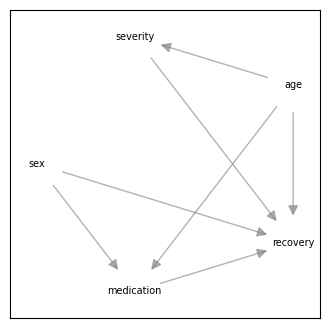

In [3]:
import networkx as nx
# import pylab as plt

plt.figure(figsize=(4, 4))

nx_graph = nx.DiGraph(model.edges())
position_dicts = nx.shell_layout(nx_graph)

nx.draw_networkx_edges(
    nx_graph,
    position_dicts,
    edge_color="gray",
    node_size=1500,
    alpha=0.6,
    arrowstyle="-|>",
    arrowsize=15,
)
nx.draw_networkx_labels(nx_graph, position_dicts, font_size=7, font_color="black")
plt.show()

In [4]:
from pgmpy.inference import CausalInference

inference = CausalInference(model=model)

proposed_backdoor_set = ["sex", "age", "severity"]

assert inference.is_valid_backdoor_adjustment_set(
    "medication", "recovery", proposed_backdoor_set
)

In [5]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split

def return_XZ_y(df, backdoor_set_list):
    return df.filter(backdoor_set_list), np.array(df.recovery)

In [6]:
df_train, df_test = train_test_split(
    df_obs.assign(recovery_cf=df_cf.recovery),
    test_size=0.2,
    random_state=42,
)

XZ_train_med0, y_train_med0 = return_XZ_y(df_train.query("medication == 0"), proposed_backdoor_set)
XZ_train_med1, y_train_med1 = return_XZ_y(df_train.query("medication == 1"), proposed_backdoor_set)

XZ_test, y_test = return_XZ_y(df_test, proposed_backdoor_set)

In [7]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import HistGradientBoostingRegressor
from statsmodels.stats.weightstats import DescrStatsW

class ConformalizedQuantileRegression(BaseEstimator):
    def __init__(self, alpha=0.1, calibration_size=0.3, random_state=42):
        self.alpha = alpha
        self.calibration_size = calibration_size
        self.random_state = random_state
    
    def _return_quantile_model(self, quantile):
        return GridSearchCV(
                estimator=HistGradientBoostingRegressor(random_state=self.random_state, loss='quantile', quantile=quantile),
                cv=KFold(shuffle=True, random_state=self.random_state),
                param_grid={"max_depth": [2, 5, 10, None]},
                scoring="neg_mean_squared_error",
                n_jobs=-1
        )
    
    def fit(self, X, y, sample_weight=None):
        if sample_weight is not None:
            X_train, X_cal, y_train, y_cal, sample_weight_train, sample_weight_cal = train_test_split(
                X, y, sample_weight, test_size=self.calibration_size, random_state=self.random_state)
        else:
            sample_weight_train, sample_weight_cal = None, None
            X_train, X_cal, y_train, y_cal = train_test_split(
                X, y, test_size=self.calibration_size, random_state=self.random_state)

        self.model_lower_ = self._return_quantile_model(quantile=self.alpha/2).fit(X_train, y_train, sample_weight=sample_weight_train)
        self.model_upper_ = self._return_quantile_model(quantile=1 - self.alpha/2).fit(X_train, y_train, sample_weight=sample_weight_train)
        
        self.y_cal_conformity_scores_ = np.maximum(
            self.model_lower_.predict(X_cal) - y_cal, 
            y_cal - self.model_upper_.predict(X_cal))
        wq = DescrStatsW(data=self.y_cal_conformity_scores_, weights=sample_weight_cal)
        self.quantile_conformity_scores_ = wq.quantile(probs=1 - self.alpha, return_pandas=False)[0]
        
        return self

    def predict(self, X):
        y_test_interval_pred_cqr = np.column_stack(
            [self.model_lower_.predict(X) - self.quantile_conformity_scores_,
             self.model_upper_.predict(X) + self.quantile_conformity_scores_])
        return y_test_interval_pred_cqr

In [8]:
df_ood_med0 = pd.concat(
    [df.assign(train_or_test=i) for i, df in enumerate([XZ_train_med0, df_test.drop(columns=["medication", "recovery", "recovery_cf"])])]
)


df_ood_med1 = pd.concat(
    [df.assign(train_or_test=i) for i, df in enumerate([XZ_train_med1, df_test.drop(columns=["medication", "recovery", "recovery_cf"])])]
)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

ood_sample_correction_med0 = LogisticRegression(
    random_state=42,
).fit(df_ood_med0.drop(columns=["train_or_test"]),
      df_ood_med0.train_or_test)

roc_auc_score(df_ood_med0.train_or_test,
              ood_sample_correction_med0.predict_proba(df_ood_med0.drop(columns=["train_or_test"]))[:, 1])

0.7558747980263515

In [10]:
ood_sample_correction_med1 = LogisticRegression(
    random_state=42,
).fit(df_ood_med1.drop(columns=["train_or_test"]),
      df_ood_med1.train_or_test)

roc_auc_score(df_ood_med1.train_or_test,
              ood_sample_correction_med1.predict_proba(df_ood_med1.drop(columns=["train_or_test"]))[:, 1])

0.7237887275594934

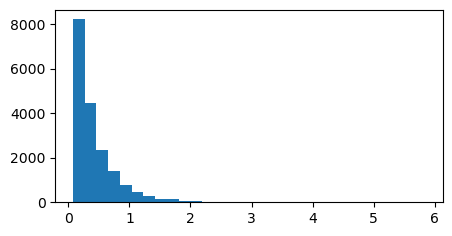

In [19]:
fig, ax = plt.subplots(figsize=(5, 2.5))
ax.hist(1/ood_sample_correction_med0.predict_proba(XZ_train_med0)[:,0] - 1, bins=30)
plt.show()

In [12]:
model_med0 = (
    ConformalizedQuantileRegression()
    .fit(XZ_train_med0, y_train_med0,
         sample_weight=1/ood_sample_correction_med0.predict_proba(XZ_train_med0)[:,0] - 1,
        )
)
y_test_interval_pred_cqr_med0 = model_med0.predict(XZ_test)

model_med1 = (
    ConformalizedQuantileRegression()
    .fit(XZ_train_med1, y_train_med1,
         sample_weight=1/ood_sample_correction_med1.predict_proba(XZ_train_med1)[:,0] - 1,
        )
)
y_test_interval_pred_cqr_med1 = model_med1.predict(XZ_test)

C:\Users\carlo\AppData\Local\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\carlo\AppData\Local\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 245, in _count_physical_cores
    raise ValueError(


In [13]:
ps =  LogisticRegression(
    random_state=42,
).fit(df_train.drop(columns=["medication", "recovery", "recovery_cf"]), df_train.medication)

roc_auc_score(df_test.medication, ps.predict_proba(XZ_test)[:, 1])

0.9806383470037248

In [14]:
df_val = (
    df_test
    .assign(pred_lower_med_0=y_test_interval_pred_cqr_med0[:, 0])
    .assign(pred_upper_med_0=y_test_interval_pred_cqr_med0[:, 1])
    .assign(ic_size_med_0=lambda df_: df_.pred_upper_med_0 - df_.pred_lower_med_0)
    .assign(pred_lower_med_1=y_test_interval_pred_cqr_med1[:, 0])
    .assign(pred_upper_med_1=y_test_interval_pred_cqr_med1[:, 1])
    .assign(ic_size_med_1=lambda df_: df_.pred_upper_med_1 - df_.pred_lower_med_1)
    .assign(prob=ps.predict_proba(XZ_test)[:, 1])
    .assign(cut=lambda df_: pd.qcut(df_.prob, q=5, labels=False))
    .assign(match=lambda df_:
            np.select(condlist=[df_.medication == 0],
                      choicelist=[(df_.recovery > df_.pred_lower_med_0) & (df_.recovery < df_.pred_upper_med_0)],
                      default=(df_.recovery > df_.pred_lower_med_1) & (df_.recovery < df_.pred_upper_med_1)))
    .assign(match_cf=lambda df_:
            np.select(condlist=[df_.medication != 0],
                      choicelist=[(df_.recovery_cf > df_.pred_lower_med_0) & (df_.recovery_cf < df_.pred_upper_med_0)],
                      default=(df_.recovery_cf > df_.pred_lower_med_1) & (df_.recovery_cf < df_.pred_upper_med_1)))
)

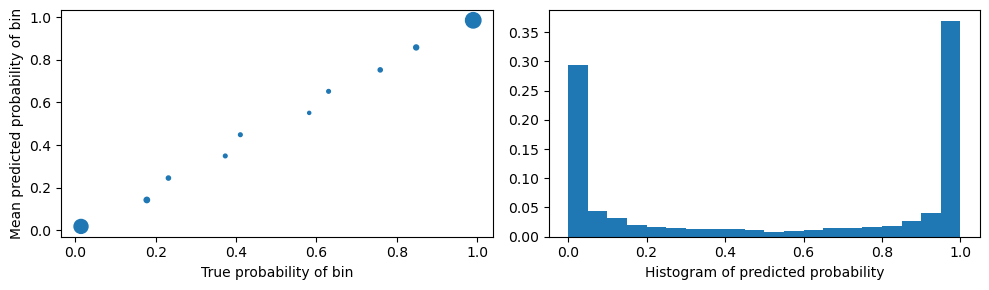

In [15]:
from cal import calibration_curve

prob_true, prob_pred, size_bin = calibration_curve(df_val.medication, df_val.prob, n_bins=10)

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].scatter(prob_true, prob_pred, s=(0.03*size_bin).astype(int))
ax[0].set_xlabel("True probability of bin")
ax[0].set_ylabel("Mean predicted probability of bin")
ax[1].hist(df_val.prob, bins=np.linspace(0, 1, 21), weights=np.ones_like(df_val.prob)/df_val.shape[0])
ax[1].set_xlabel("Histogram of predicted probability")
plt.tight_layout()

In [16]:
from scipy.stats import bootstrap
def bootstrap_ci(x, ci=0.95):
    boot = bootstrap((x,), np.mean, confidence_level=ci)
    return np.round(boot.confidence_interval, 5)

In [17]:
aux1 = (
    df_val
    .groupby("cut")
    .match
    .apply(bootstrap_ci)
    .to_frame()
    .rename(columns={"match": "match_confidence_interval"})
)

aux2 = (
    df_val
    .groupby("cut")
    .match_cf
    .apply(bootstrap_ci)
    .to_frame()
    .rename(columns={"match_cf": "match_cf_confidence_interval"})
)

aux3 = (
    df_val
    .groupby("cut")
    .agg({"match": np.mean, "match_cf": np.mean, "ic_size_med_0": np.mean, "ic_size_med_1": np.mean})
    .rename(columns=lambda col: col + "_mean")
)

pd.concat([aux1, aux2, aux3], axis=1).reset_index()

,cut,match_confidence_interval,match_cf_confidence_interval,match_mean,match_cf_mean,ic_size_med_0_mean,ic_size_med_1_mean
0,0,"[0.914, 0.937]","[0.79729, 0.8315]",0.9260,0.8145,16.083436,10.480352
1,1,"[0.8875, 0.9135]","[0.853, 0.8825]",0.9010,0.8685,18.549757,10.011604
2,2,"[0.8775, 0.9045]","[0.8535, 0.8835]",0.8915,0.8695,21.239289,12.913200
3,3,"[0.899, 0.924]","[0.6905, 0.73015]",0.9120,0.7105,26.119253,15.579364
4,4,"[0.8915, 0.917]","[0.1725, 0.2065]",0.9050,0.1890,30.549546,19.592550


Esperava que o primeiro quantil tivesse um IC size do med1 maior já que teoricamente temos poucos exemplos para essa região. Mas aparentemente, ele tem bastante confiança mesmo nessa região...

In [18]:
aux1 = (
    df_val
    .groupby(["cut", "medication"])
    .match
    .apply(bootstrap_ci)
    .to_frame()
    .rename(columns={"match": "match_confidence_interval"})
)

aux2 = (
    df_val
    .groupby(["cut", "medication"])
    .match_cf
    .apply(bootstrap_ci)
    .to_frame()
    .rename(columns={"match_cf": "match_cf_confidence_interval"})
)

aux3 = (
    df_val
    .groupby(["cut", "medication"])
    .agg({"match": np.mean, "match_cf": np.mean, "ic_size_med_0": np.mean, "ic_size_med_1": np.mean}) # 
    .rename(columns=lambda col: col + "_mean")
)

pd.concat([aux1, aux2, aux3], axis=1).reset_index().sort_values(by=["medication", "cut"])

C:\Users\carlo\AppData\Local\anaconda3\lib\site-packages\scipy\stats\_resampling.py:144: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\carlo\AppData\Local\anaconda3\lib\site-packages\scipy\stats\_resampling.py:97: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


,cut,medication,match_confidence_interval,match_cf_confidence_interval,match_mean,match_cf_mean,ic_size_med_0_mean,ic_size_med_1_mean
0,0,0.0,"[0.91433, 0.93737]","[0.79709, 0.83066]",0.926353,0.814128,16.083279,10.479949
2,1,0.0,"[0.89136, 0.91852]","[0.84737, 0.87941]",0.906029,0.863661,18.511663,9.967753
4,2,0.0,"[0.86065, 0.90452]","[0.87871, 0.92129]",0.883871,0.900645,20.257201,12.377278
6,3,0.0,"[0.70588, 0.94118]","[0.70588, 0.94118]",0.852941,0.852941,27.670396,14.823145
1,0,1.0,"[0.25, 1.0]","[nan, nan]",0.750000,1.000000,16.161822,10.681355
3,1,1.0,"[0.77987, 0.89308]","[0.87421, 0.95597]",0.842767,0.924528,18.990834,10.519336
5,2,1.0,"[0.87837, 0.91265]","[0.82939, 0.86939]",0.896327,0.849796,21.860609,13.252253
7,3,1.0,"[0.8998, 0.92472]","[0.68667, 0.72787]",0.913021,0.708037,26.092428,15.592442
8,4,1.0,"[0.8915, 0.917]","[0.1725, 0.2065]",0.905000,0.189000,30.549546,19.592550


Tem regiões que não tem ninguém do outro tratamento kkkk ._.

Trocar o dataset

___